# Importamos librerias

In [1]:
 import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import kagglehub
import os
from sklearn.metrics import average_precision_score

# Función load_data

Función util para el preprocesamiento de los datos del dataframe a utilizar.

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df.sample(frac=0.01, random_state=42).reset_index(drop=True)
    df = df[['name', 'main_category', 'sub_category', 'ratings', 'no_of_ratings']].fillna('')
    df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce').fillna(0)
    df['no_of_ratings'] = pd.to_numeric(df['no_of_ratings'], errors='coerce').fillna(0)
    df['text_features'] = df['name'] + ' ' + df['main_category'] + ' ' + df['sub_category']
    return df

# Función train_recommender

Función encargada del diseño del modelo, donde se realiza la vectorización de texto y cálculo de la similitud

In [24]:
def train_recommender(df):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['text_features'])
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return vectorizer, similarity_matrix

# Función recommend

Se genera la recomendación del usuario a partir del contenido, número de puntuaciones y puntuación total del producto.

In [4]:
def recommend(product_name, df, vectorizer, similarity_matrix, top_n=5):
    if product_name not in df['name'].values:
        return []
    idx = df[df['name'] == product_name].index[0]
    scores = list(enumerate(similarity_matrix[idx]))

    # Incorporar ratings y número de ratings en la recomendación
    scores = [(i, score * df.iloc[i]['ratings'] * np.log1p(df.iloc[i]['no_of_ratings'])) for i, score in scores]
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    recommendations = [df.iloc[i[0]]['name'] for i in scores]
    return recommendations

# Función evaluate_recommendations

Realizamos la evaluación del modelo a partir de la métrica Mean Average Precision (MAP)

In [5]:
def evaluate_recommendations(df, vectorizer, similarity_matrix):
    y_true_list = []
    y_scores_list = []
    sample_size = min(100, len(df))
    sampled_products = df['name'].sample(sample_size)

    for product in sampled_products:
        recommendations = recommend(product, df, vectorizer, similarity_matrix, top_n=5)
        relevant_items = df[df['main_category'] == df[df['name'] == product]['main_category'].values[0]]['name'].tolist()
        y_true = [1 if rec in relevant_items else 0 for rec in recommendations]
        y_scores = list(range(len(recommendations), 0, -1))

        if sum(y_true) > 0:
            y_true_list.append(y_true)
            y_scores_list.append(y_scores)

    map_score = np.mean([average_precision_score(y_true, y_score) for y_true, y_score in zip(y_true_list, y_scores_list)])
    return map_score

# Función save_model

Conectamos con drive para guardar el modelo en .pkl y que sea de uso para la herramienta web

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def save_model(vectorizer, similarity_matrix, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump((vectorizer, similarity_matrix), f)

# Implementación de la lógica
Realizamos el cargue de la data y la ejecución de las funciones mencionadas para la obtención de los resultados

In [21]:
if __name__ == "__main__":
    path = kagglehub.dataset_download("lokeshparab/amazon-products-dataset")
    dataset_path = "/root/.cache/kagglehub/datasets/lokeshparab/amazon-products-dataset/versions/2"
    file_path = os.path.join(path, 'Amazon-Products.csv')
    df = load_data(file_path)

    vectorizer, similarity_matrix = train_recommender(df)
    save_model(vectorizer, similarity_matrix, "/content/drive/My Drive/SM10/RN/Trabajo3/Códigos/SE-usuarioProducto.pkl")

    # Evaluación del modelo con Mean Average Precision (MAP)
    map_score = evaluate_recommendations(df, vectorizer, similarity_matrix)
    print(f"Mean Average Precision (MAP): {map_score}")

    # Ejemplo de recomendación
    product_name = df['name'].iloc[0]  # Primer producto del dataset
    recommendations = recommend(product_name, df, vectorizer, similarity_matrix)
    print(f"Recomendaciones para {product_name}: {recommendations}")

Mean Average Precision (MAP): 0.9158472222222223
Recomendaciones para MyBlush Women Top: ['MyBlush Women Top', 'NIVIK Combo Pack of 3 Cotton t-Shirts for Women', "Puma Women's Regular Fit T-Shirt", 'Van Heusen Athleisure Women Track Pants', "Neysa Women's Cotton Lycra Maxi Dress"]


Podemos observar una metrica MAP exitosa de 0.91 y unas recomendaciones acordes al producto

# Información de las categorias

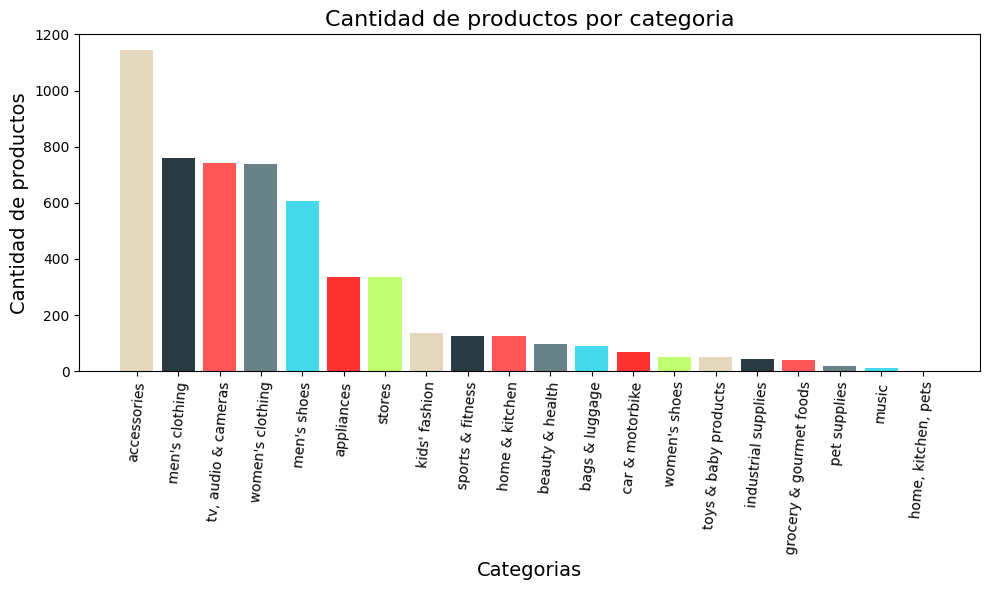

In [14]:
import matplotlib.pyplot as plt
main_category = df['main_category'].value_counts()
maincat_counts = main_category.values
colors = ['#e4d9bd', '#293a42', '#ff5757', '#698288', '#44daec', '#ff3131', '#c1ff72']
# grafico
plt.figure(figsize=(10, 6))
bars = plt.bar(main_category.index, maincat_counts, color=colors)
plt.title('Cantidad de productos por categoria', fontsize=16)
plt.xlabel('Categorias', fontsize=14)
plt.ylabel('Cantidad de productos', fontsize=14)
plt.xticks(rotation=85)
plt.tight_layout()
plt.show()

# Información de las sub categorias

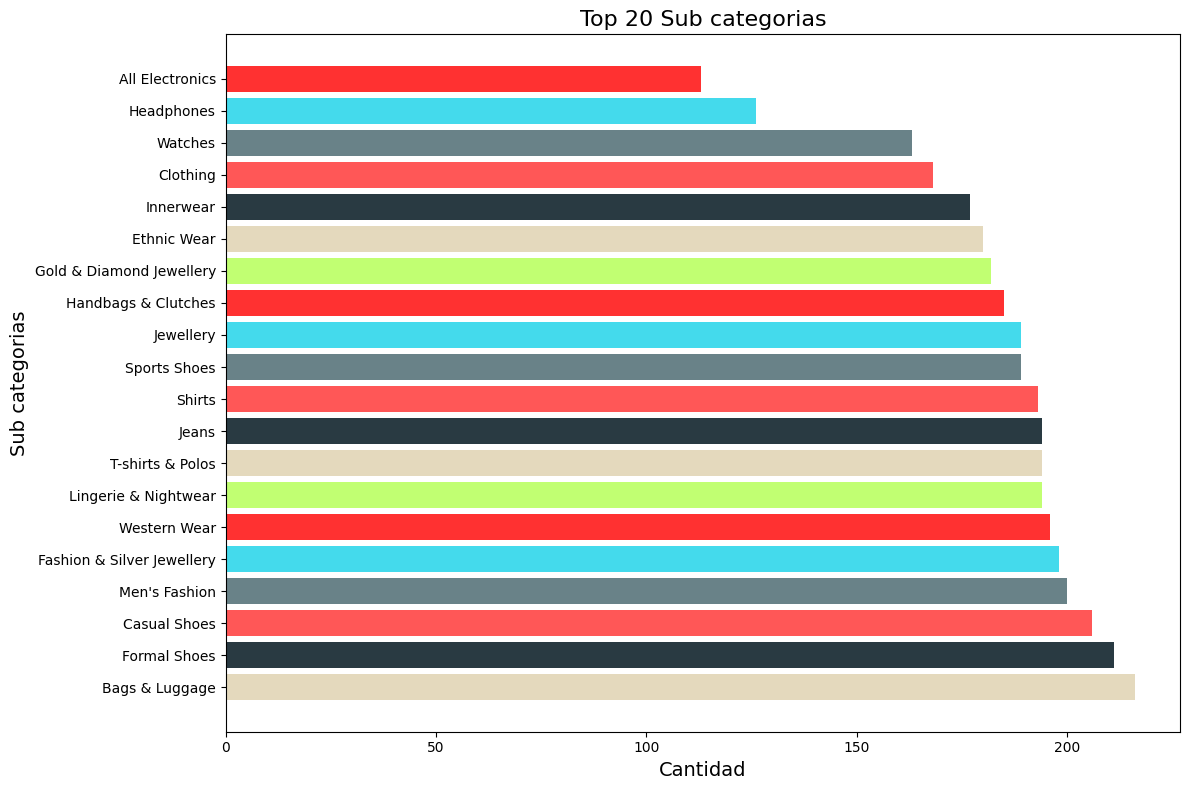

In [15]:
subcat_counts = df['sub_category'].value_counts()
top_20_subcats = subcat_counts.nlargest(20)
colors = ['#e4d9bd', '#293a42', '#ff5757', '#698288', '#44daec', '#ff3131', '#c1ff72'] * 3
plt.figure(figsize=(12, 8))
plt.barh(top_20_subcats.index, top_20_subcats, color=colors[:len(top_20_subcats)])  # Use only necessary colors
plt.title('Top 20 Sub categorias', fontsize=16)
plt.xlabel('Cantidad', fontsize=14)
plt.ylabel('Sub categorias', fontsize=14)
plt.tight_layout()
plt.show()

Información de las puntuaciones

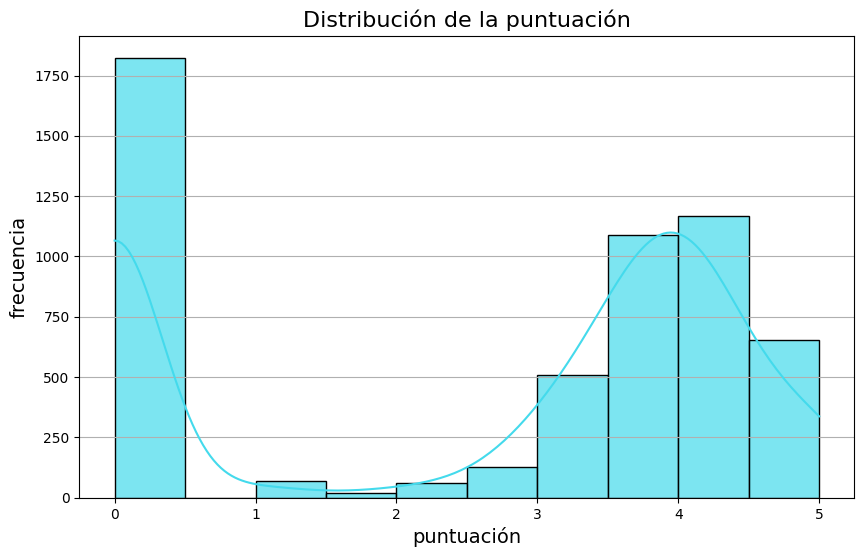

In [23]:
import seaborn as sns
rating = pd.to_numeric(df['ratings'])
# grafico
plt.figure(figsize=(10, 6))
sns.histplot(rating, bins=10, kde=True, color='#44daec', alpha=0.7)
plt.title('Distribución de la puntuación', fontsize=16)
plt.xlabel('puntuación', fontsize=14)
plt.ylabel('frecuencia', fontsize=14)
plt.grid(axis='y')
plt.show()

# Información del número de categorias

<ipython-input-17-144fd82c6c58>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette=colors[:len(rating_counts)])  # Use a subset of colors


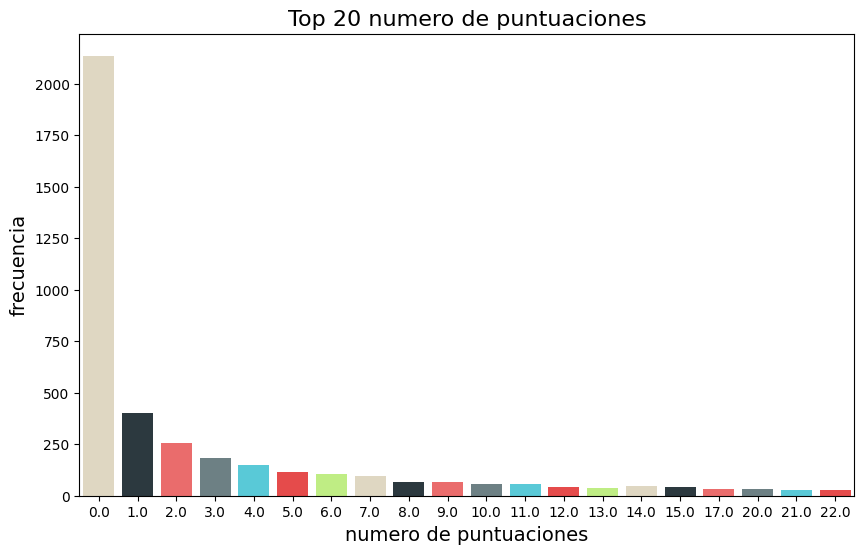

In [17]:
rating_counts = df['no_of_ratings'].value_counts().nlargest(20)
# grafico
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette=colors[:len(rating_counts)])  # Use a subset of colors
plt.title('Top 20 numero de puntuaciones', fontsize=16)
plt.xlabel('numero de puntuaciones', fontsize=14)
plt.ylabel('frecuencia', fontsize=14)
plt.show()